<a href="https://colab.research.google.com/github/24kool/ML_NCAA-Performance/blob/master/Potential_NBA_Stars_from_the_NCAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Potential NBA Stars from the NCAA

Project: Does a good performance in the NCAA correlate to a good performance in the NBA, using a player's stats from their NCAA career. I will create a model using methods learned in class to scout for future prominent potential stars in the NBA. Using the data and the ncaa statistics for each player.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

# Data Preparation

In [3]:
#I use the following statements to read in csv files of NBA datasets that I found online.

#The ncaa_players dataset will contain information about all NCAA basketball players from 1947 to 2018.
#There are 34 columns of data including names of the players, the university they played for, their birth years,
#their active years in the NCAA, their stats, their positions, and their physical measurements.
#dataset source: https://data.world/bgp12/nbancaacomparisons/workspace/file?filename=players.csv
ncaa_players = pd.read_csv('players.csv')

#The player info dataset will contain physical information on players such as height and their in-game statistics.
#dataset source: https://www.kaggle.com/justinas/nba-players-data
player_info = pd.read_csv('all_seasons.csv')

###################################################################################################################

#The following 5 datasets are all part of a larger group of data based on the 2004-2021 NBA seasons.

#The games dataset will contain information about all games from the 2004 season until the 2021 season.
#There are 21 total columns of data with details on teams such as shot percentages while either at home or away.
#dataset source: https://www.kaggle.com/nathanlauga/nba-games?select=games.csv
games = pd.read_csv('games.csv')

#The players_games_details dataset will contain details about every player's statistics for a given NBA game.
#This dataset contains all relevant statistics for players such as points, rebounds, assists, blocks, steals, etc.
#dataset source: https://www.kaggle.com/nathanlauga/nba-games?select=games_details.csv
players_games_details = pd.read_csv('games_details.csv')

#The recent_nba_players dataset will contain basic player details such as their name, id, team id, player id, and season.
#dataset source: https://www.kaggle.com/nathanlauga/nba-games?select=players.csv
recent_nba_players = pd.read_csv('nbaplayers.csv')

#The rankings dataset will contain information about teams and their standings at different points in the season.
#This dataset also contains winning percentages of teams at home vs. at away games.
#dataset source: https://www.kaggle.com/nathanlauga/nba-games?select=ranking.csv
rankings = pd.read_csv('ranking.csv')

#The teams dataset contains basic information about NBA teams such as the year they were founded, abbreviations,
#general managers, the city they are from, and their arenas.
#dataset source: https://www.kaggle.com/nathanlauga/nba-games?select=teams.csv
teams = pd.read_csv('teams.csv')

<ipython-input-3-b30d884eeb9c>:25: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  players_games_details = pd.read_csv('games_details.csv')


In [4]:
#The first thing I want to do is drop some unnecessary columns.
#There is also code to replace the string types in the columns as floats so that I can work with numbers later.

In [25]:
#I use the following code to remove a bunch of rows with missing values - since the dataset contains very little
#values in the NCAA_efgpct column, I decided to drop that column first.
ncaa_players = pd.read_csv('players.csv')
ncaa_players.drop(['Unnamed: 0', 'url', 'NCAA_efgpct'], axis=1, inplace=True)
ncaa_players.dropna(axis=0, inplace=True)
ncaa_players.head(7)

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,162.0,2.3,0.354,...,0.372,2.7,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
5,1997,2008,"December 11, 1976",University of California,6-9,Shareef Abdur-Rahim,F,225.0,0.6,0.297,...,0.381,0.3,14.2,0.518,7.4,0.683,8.9,6.1,28.0,21.1
10,2006,2009,"January 21, 1983",Pepperdine University,6-5,Alex Acker,G,185.0,0.8,0.320,...,0.411,1.4,11.2,0.457,5.1,0.823,3.5,2.9,88.0,14.5
14,2013,2018,"October 6, 1990",Baylor University,6-7,Quincy Acy,F,240.0,1.5,0.355,...,0.429,0.0,6.0,0.602,3.6,0.708,3.6,2.5,139.0,9.8
18,2007,2009,"June 20, 1984",University of Arizona,6-4,Hassan Adams,G,220.0,0.0,0.000,...,0.311,0.6,11.6,0.499,5.8,0.704,2.7,1.9,130.0,14.0
19,2015,2016,"July 8, 1994","University of California, Los Angeles",6-5,Jordan Adams,G,209.0,0.8,0.385,...,0.331,1.4,11.6,0.467,5.4,0.839,5.0,4.2,69.0,16.4
25,2011,2015,"February 10, 1986",University of Connecticut,6-7,Jeff Adrien,F,245.0,0.0,0.000,...,0.333,0.0,8.8,0.515,4.5,0.606,4.9,3.0,133.0,12.1


**Part 1: Exploratory Data Analysis(EDA) and General Visualizations**

In [26]:
#I wanted to use the next few cells to plot different things between NCAA and NBA statistics such as
#players' PPG(Point Per Game) in the NCAA vs. the NBA, games played in each league, field goal stats between the leagues,
#3 point stats between the leagues, freethrow stats between the leagues, and shot percentages in each league.

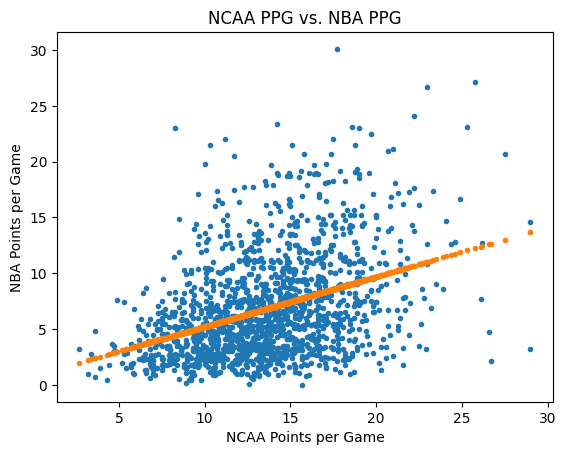

In [30]:
plt.title('NCAA PPG vs. NBA PPG')
plt.xlabel('NCAA Points per Game')
plt.ylabel('NBA Points per Game')
plt.plot(ncaa_players.NCAA_ppg, ncaa_players.NBA_ppg, '.')
m, b = np.polyfit(ncaa_players.NCAA_ppg, ncaa_players.NBA_ppg, 1)
plt.plot(ncaa_players.NCAA_ppg, m*ncaa_players.NCAA_ppg+b, '.')
#Looking at this plot, there does seem to be a noticeable positive correllation between NCAA ppg and NBA ppg and shown by the linear regression line.
#However, it is also noticeable that the NCAA points cluster is more apparent in the 10-20 range, while
#the NBA points cluster in the 0-10 range. This does make sense intuitively as it would be naturally
#be much harder to score against the best of the best defenders in the NBA as opposed to the NCAA.

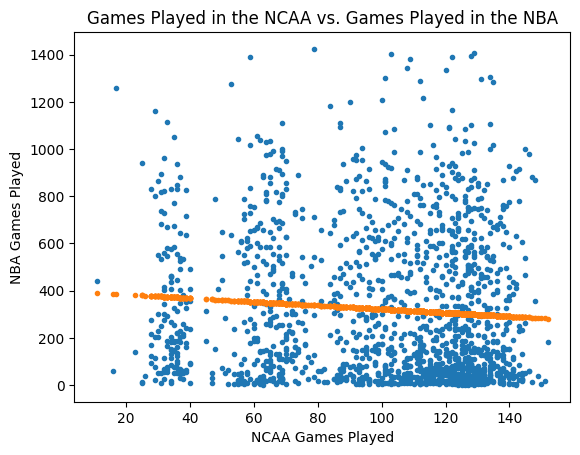

In [31]:
plt.title('Games Played in the NCAA vs. Games Played in the NBA')
plt.xlabel('NCAA Games Played')
plt.ylabel('NBA Games Played')
plt.plot(ncaa_players.NCAA_games, ncaa_players.NBA_g_played, '.')
m, b = np.polyfit(ncaa_players.NCAA_games, ncaa_players.NBA_g_played, 1)
plt.plot(ncaa_players.NCAA_games, m*ncaa_players.NCAA_games+b, '.')
#This plot is interesting because we can see sort of where the 4 years of NCAA play are divided for players
#(after some further googling, this lines up with the 25-35 games teams tend to play in the NCAA season) and we
#can see that towards the higher end of NCAA games played, there is a much larger group of players that don't get
#to play any games in the NBA at all - this could support that the better players will often get drafted earlier
#in their careers and don't get to play as many NCAA games.

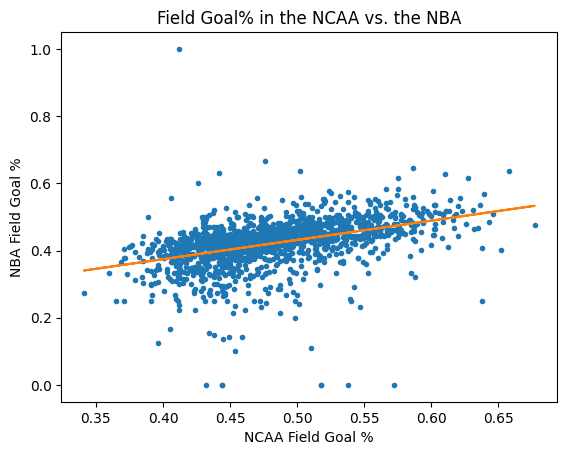

In [32]:
plt.title('Field Goal% in the NCAA vs. the NBA')
plt.xlabel('NCAA Field Goal %')
plt.ylabel('NBA Field Goal %')
ncaa_players = ncaa_players.rename(columns={'NBA_fg%': 'NBA_fgpct'})
plt.plot(ncaa_players.NCAA_fgpct, ncaa_players.NBA_fgpct, '.')
m, b = np.polyfit(ncaa_players.NCAA_fgpct, ncaa_players.NBA_fgpct, 1)
plt.plot(ncaa_players.NCAA_fgpct, m*ncaa_players.NCAA_fgpct+b)
#In this plot comparing field goal percentages between the NCAA and NBA, we can see the greater variation in shot
#percentages in the NCAA - this variation however, seems to be corrected once the players move to the NBA. Once
#in the NBA, shooting percentages seem to coalesce into a smaller range and we can see the trend being very strong
#near 40%. Disregarding the few outliers, we can see that even the best shooters in the NCAA becoming a lot more
#average in the NBA percentage-wise and there is still a very slight positive correlation between NCAA and NBA FG%.

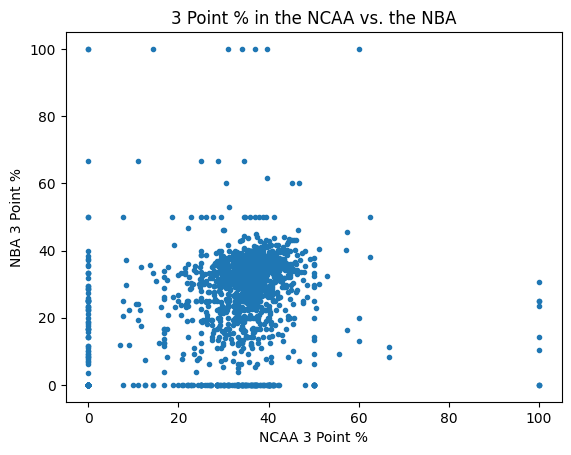

In [33]:
plt.title('3 Point % in the NCAA vs. the NBA')
plt.xlabel('NCAA 3 Point %')
plt.ylabel('NBA 3 Point %')
plt.plot(ncaa_players.NCAA__3ptpct * 100, ncaa_players.NBA__3ptpct * 100, '.')
#From the below 3 Point % plot, there were two noticeable things to me at first glance. The 3 point percentages
#between the NCAA and NBA seemed much more tightly bound and even between the leagues at around 30-40% for most
#players and seem to correlate pretty strongly between the two leagues. The other noticeable thing is that either
#the players would be in the previously mentioned percentage range OR would lie in the 0% range - this tells us
#something. From this observation, I want to infer that players that feel like they CAN shoot 3s tend to have a
#decent average percentage at around 30-40% and therefore will attempt 3 point shots; on the other hand, players
#that don't have confidence in their 3 point shooting ability will not attempt ANY 3 point shots at all and will
#only attempt other types of shots, which would explain why there are a large amount of players in the 0% 3 point
#shooting range during their career.

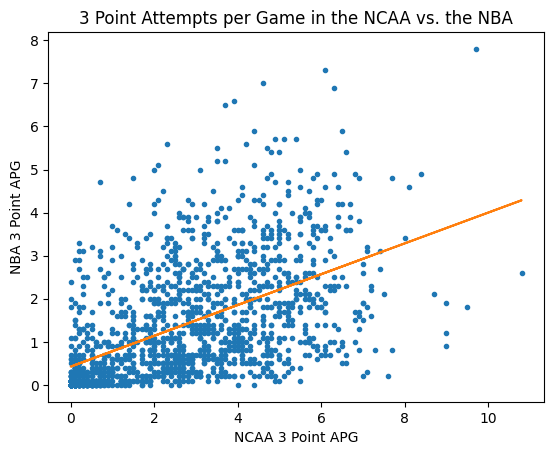

In [34]:
plt.title('3 Point Attempts per Game in the NCAA vs. the NBA')
plt.xlabel('NCAA 3 Point APG')
plt.ylabel('NBA 3 Point APG')
plt.plot(ncaa_players.NCAA__3ptapg, ncaa_players.NBA__3ptapg, '.')
m, b = np.polyfit(ncaa_players.NCAA__3ptapg, ncaa_players.NBA__3ptapg, 1)
plt.plot(ncaa_players.NCAA__3ptapg, m*ncaa_players.NCAA__3ptapg+b)
#The below plot of 3 point attempts per game just further shows similar trends as previous plots in that there are
#on average more 3 point attempts per game in the NCAA than in the NBA - we can observe that most players attempt
#between 0-6 3 point shots in the NCAA, while this gets narrowed down in the NBA and over half of these players
#will decrease their 3 point shot attempts to between 0-2 a game in the NBA. However, there is still a noticeable
#positive correlation between the two leagues in that players who attempt more 3 point shots in the NCAA will tend
#to attempt more in the NBA as well.

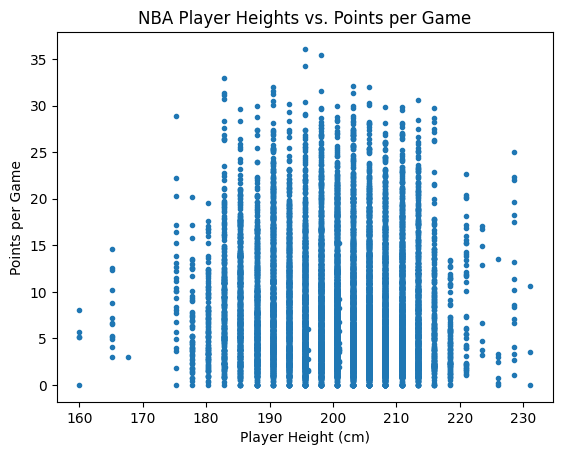

In [36]:
plt.title('NBA Player Heights vs. Points per Game')
plt.xlabel('Player Height (cm)')
plt.ylabel('Points per Game')
plt.plot(player_info.player_height, player_info.pts, '.')
#With the exception of the lower end of the height scale towards the 160-170cm range, there seems to be little
#correlation between height and points per game in the NBA. From this plot, it can be assumed that height is
#not so great of an indicator for how a player will do in their NBA career.

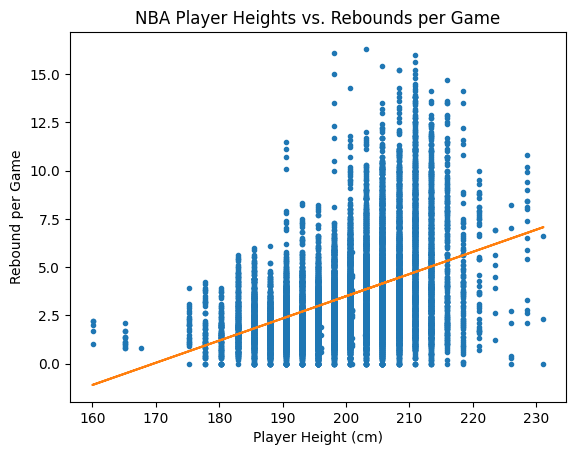

In [37]:
plt.title('NBA Player Heights vs. Rebounds per Game')
plt.xlabel('Player Height (cm)')
plt.ylabel('Rebound per Game')
plt.plot(player_info.player_height, player_info.reb, '.')
m, b = np.polyfit(player_info.player_height, player_info.reb, 1)
plt.plot(player_info.player_height, m*player_info.player_height+b)
#In this plot, as opposed to the height vs. ppg plot, there does seem to be a much more noticeable upward trend
#in rebounds per game as height increases. This makes sense intuitively as height is definitely much more of a
#factor when it comes to rebounding the ball - maybe players are sought after for their height not because it
#would make it easier for them to score, but because their rebounding potential would be much higher.

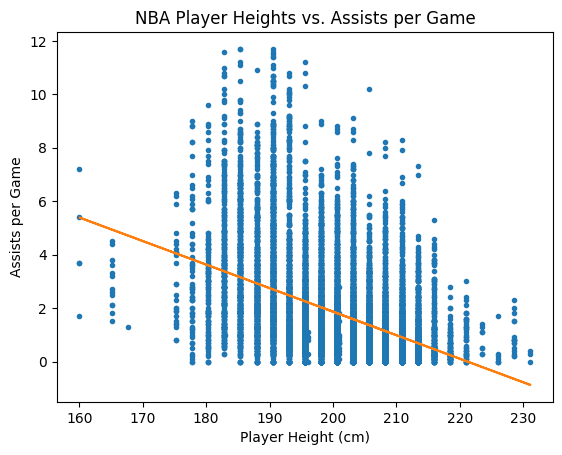

In [38]:
plt.title('NBA Player Heights vs. Assists per Game')
plt.xlabel('Player Height (cm)')
plt.ylabel('Assists per Game')
plt.plot(player_info.player_height, player_info.ast, '.')
m, b = np.polyfit(player_info.player_height, player_info.ast, 1)
plt.plot(player_info.player_height, m*player_info.player_height+b)
#This is also a very interesting plot because I really did not expect there to be any correlation between height
#and assists per game in the NBA, but from the plot, there does seem to definitely be some negative correlation
#between the two - as player height increases, assists per game trends downwards overall. This could possibly be
#explained by the fact that the taller players could be rebounding the ball and passing it across the court to
#shorter players focusing more on offense. Since shorter players would be rebounding less, their role on the court
#could be to get the ball to other teammates in order to score the points.

Part 2:

In [40]:
df = pd.read_csv('players.csv', index_col=0)
df.head(7)

,active_from,active_to,birth_date,college,height,name,position,url,weight,NBA__3ptapg,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240.0,0.0,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225.0,0.0,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162.0,2.3,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997,2008,"December 11, 1976",University of California,6-9,Shareef Abdur-Rahim,F,/players/a/abdursh01.html,225.0,0.6,...,0.3,NaN,14.2,0.518,7.4,0.683,8.9,6.1,28.0,21.1
6,1977,1981,"May 6, 1954",Indiana University,6-7,Tom Abernethy,F,/players/a/abernto01.html,220.0,0.0,...,NaN,NaN,4.5,0.533,2.4,0.689,1.7,1.1,110.0,5.9


Examine counts of non-null values per variable

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4576 entries, 0 to 4575
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_from       4576 non-null   int64  
 1   active_to         4576 non-null   int64  
 2   birth_date        4547 non-null   object 
 3   college           4274 non-null   object 
 4   height            4575 non-null   object 
 5   name              4576 non-null   object 
 6   position          4575 non-null   object 
 7   url               4576 non-null   object 
 8   weight            4570 non-null   float64
 9   NBA__3ptapg       3448 non-null   float64
 10  NBA__3ptpct       2953 non-null   float64
 11  NBA__3ptpg        3448 non-null   float64
 12  NBA_efgpct        3426 non-null   float64
 13  NBA_fg%           4548 non-null   float64
 14  NBA_fg_per_game   4576 non-null   float64
 15  NBA_fga_per_game  4576 non-null   float64
 16  NBA_ft%           4378 non-null   float64


Rename some of the NBA columns to be consistent in naming with names of NCAA columns:

In [42]:
df = df.rename({'NBA_fg%': 'NBA_fgpct',
                'NBA_fg_per_game': 'NBA_fgpg',
                'NBA_fga_per_game': 'NBA_fgapg',
                'NBA_ft%': 'NBA_ftpct',
                'NCAA_ft': 'NCAA_ftpct',
                'NBA_ft_per_g': 'NBA_ftpg',
                'NBA_fta_p_g': 'NBA_ftapg',
                'NBA_g_played': 'NBA_games'
                }, axis=1)
# Lists of NBA and NCAA columns
NBA_columns = [c for c in df.columns if 'NBA' in c]
NCAA_columns = [c for c in df.columns if 'NCAA' in c]
# Sort lists of columns to have more consistency later
NBA_columns.sort()
NCAA_columns.sort()
# Move NBA_efgpct to the end, because there will be no corresponding NCAA column
NBA_columns.remove('NBA_efgpct')
NBA_columns.append('NBA_efgpct')

# Data cleaning

We can see that most of the columns contain null values. All values in the  NCAA_efgpct column are null, therefore we can discard the whole column. There are 2598 non-null values in columns NCAA_games, NCAA_ppg and NCAA_ftpg. We will assume that players with null values in the NCAA_games column did not go to college and remove them completely from the dataset. Since we are interested in predicting performance in the NBA, we will also discard all rows for which at least one NBA column contains a missing value. The remaining missing values in the NCAA columns we will replace using the k-Nearest Neighbors approach - for each missing value, we will find the average value in that column of k other players that have most similar NCAA statistics.

In [43]:
# Remove the all-null column
df.drop('NCAA_efgpct', axis=1, inplace=True)
NCAA_columns.remove('NCAA_efgpct')
# Remove rows with null values in NCAA_games
df = df[df['NCAA_games'].notnull()]
# Remove rows with any of NBA values missing
df = df[df[NBA_columns].notnull().all(axis=1)]
# Use KNNImputer with 10 neighbors to impute missing values
imputer = KNNImputer(n_neighbors=10)
df[NCAA_columns] = imputer.fit_transform(df[NCAA_columns])

# Correlation Analysis

Plot the correlation of the NCAA columns versus themselves as a heatmap:

<ipython-input-44-70daf339b160>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().loc[NCAA_columns, NCAA_columns], vmin=-1.0, vmax=1.0,


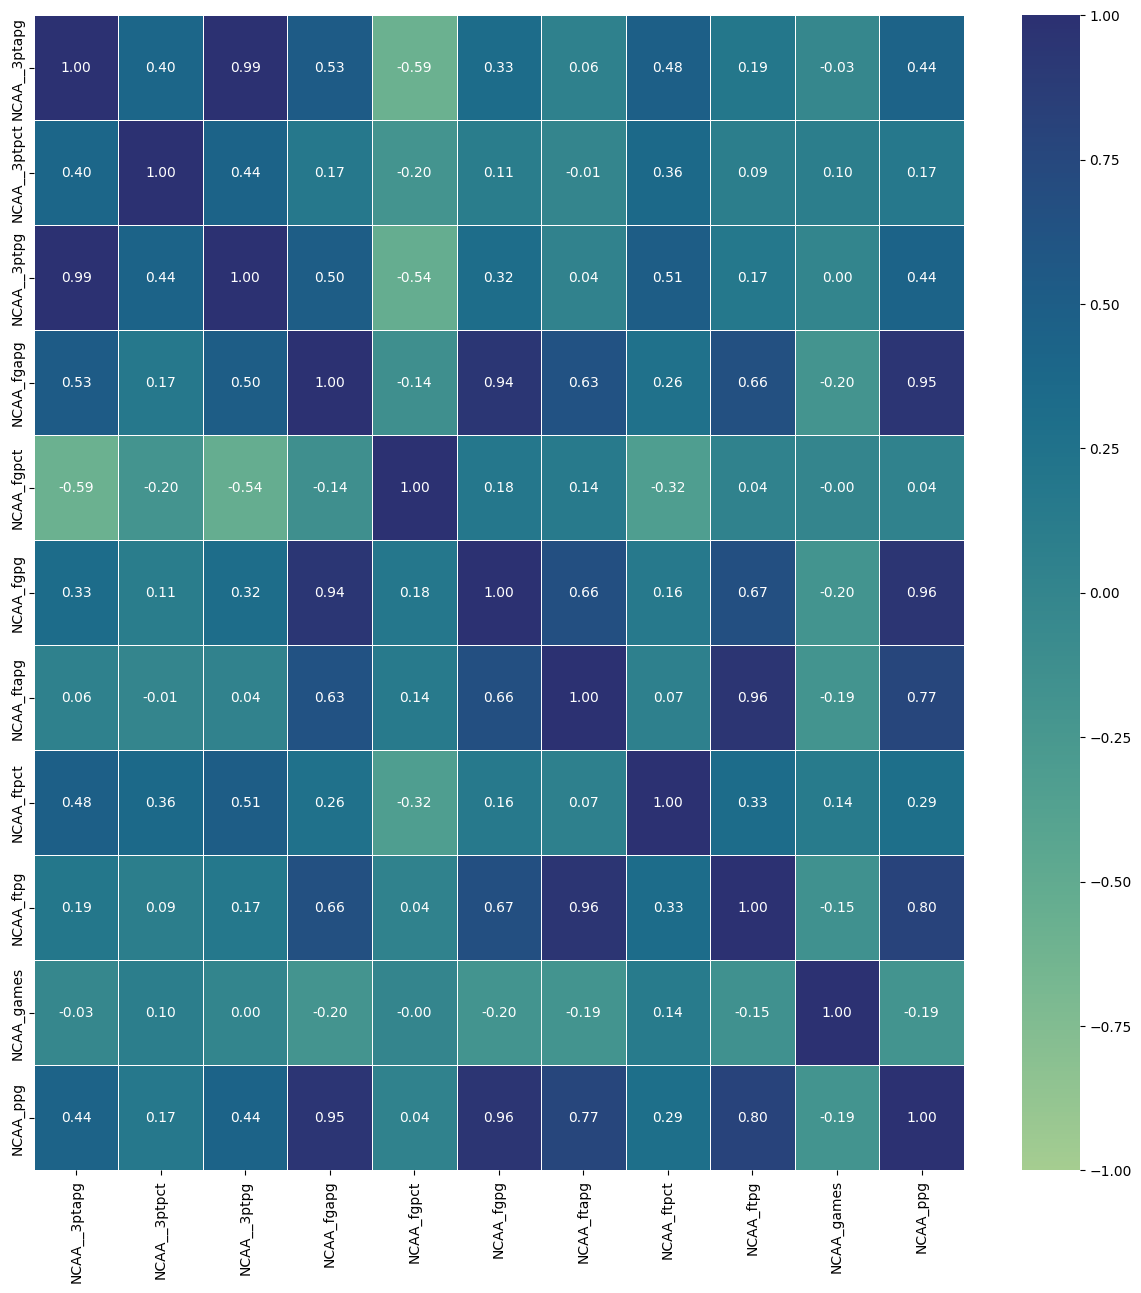

In [44]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr().loc[NCAA_columns, NCAA_columns], vmin=-1.0, vmax=1.0,
            annot=True, linewidth=.5, fmt=".2f", cmap="crest")
plt.show()

Most of performance metrics in the NCAA are correlated between themselves. Many of them are very strongly correlated, meaning that multicollinearity exists in the data.

Plot the correlation matrix of the NCAA columns versus the NBA columns as a heatmap:

<ipython-input-45-68a1bb588c61>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().loc[NCAA_columns, NBA_columns], vmin=-1.0, vmax=1.0,


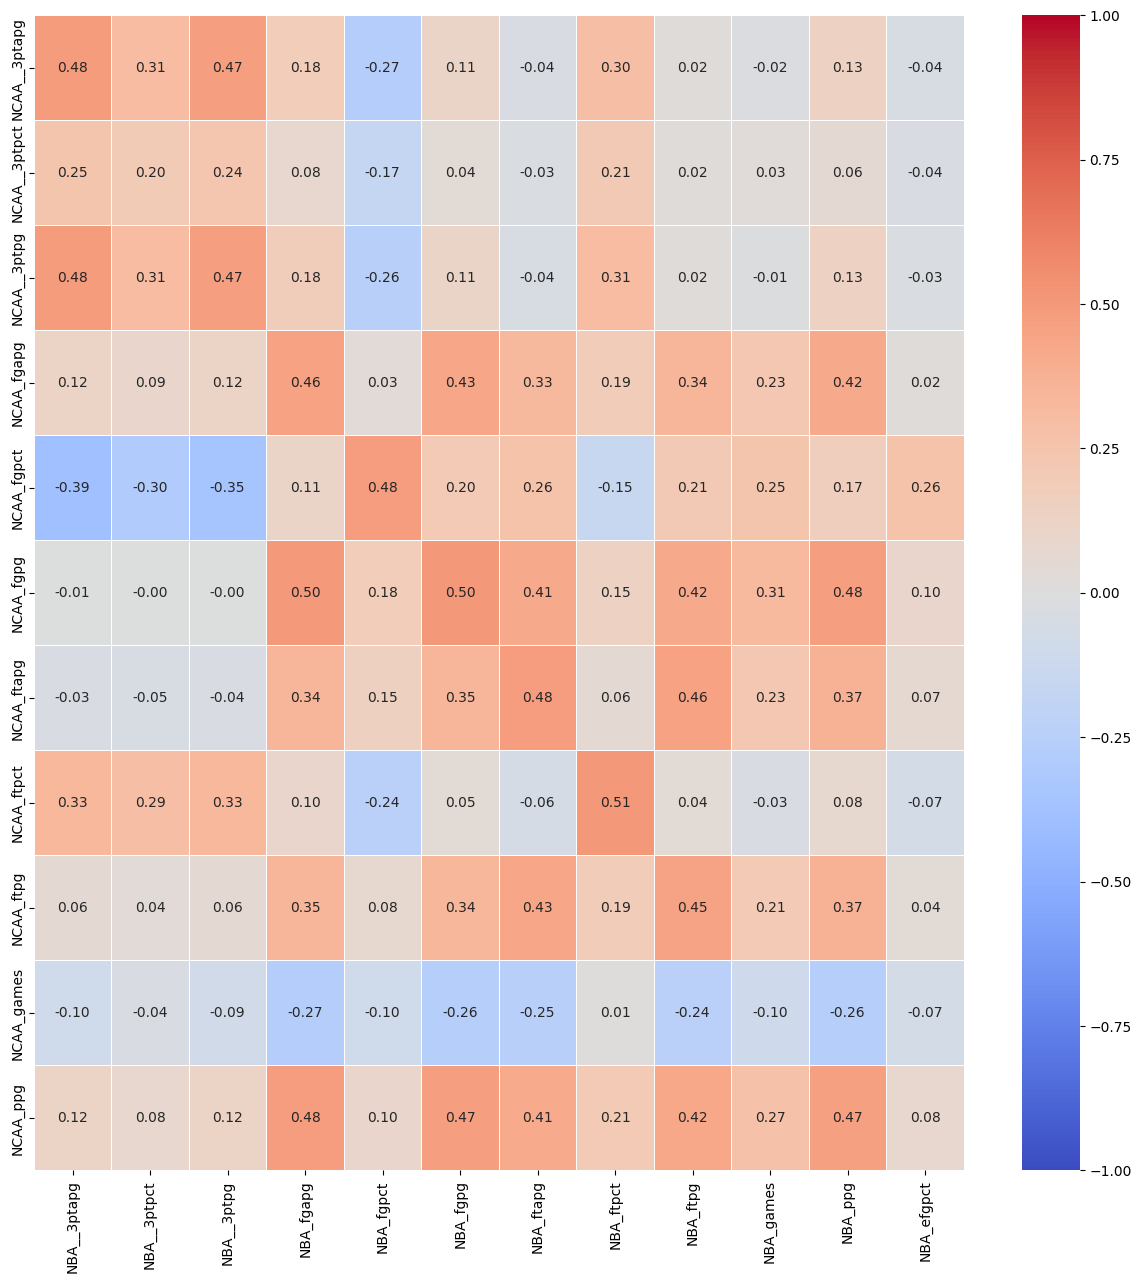

In [45]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr().loc[NCAA_columns, NBA_columns], vmin=-1.0, vmax=1.0,
            annot=True, linewidth=.5, fmt=".2f", cmap="coolwarm")
plt.show()

Sorting the lists of columns earlier, the diagonal on the heatmap that starts from the top left corner shows correlations between the same metrics of performance in the NCAA and the NBA.  
We can see that most of the metrics of performance in the NCAA have some correlation with the corresponding metrics of performance in the NBA (0.45-0.51). Exceptions to this are the three-point percentage metrics and the number of games played in the NBA or NCAA. There are also some good correlations between the non-matching columns. The NBA_efgpct column that has no matching NCAA column has no correlation with any other column except a weak correlation with the NCAA_fgpct column.


# Prediction Models

To find out how performance of players in the NCAA correlates to the performance in NBA, I will apply different machine learning techniques, using the NCAA columns as features and the NBA columns as targets. I will split the data randomly into the training and test datasets, rescale the data using the mean and variance of the training set. I will use the mean squared error and $R^2$ score as the evaluation metrics to decide which model performed the best. I will consider the following models: linear regression with l2 regularization, random forest regression, SVM, neural network and a set of linear models that predict a performance metrics in the NBA only from the same performance metrics in the NCAA.

## Train/Test Datasets Preparation

In [46]:
# Split the data into the training and test sets (70%/30%)
X = df[NCAA_columns]
y = df[NBA_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=111)
# Normalize the training features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test) # Use same mean/variance as for the training set
# Normalize the target variables to obtain meaningful average MSE during evaluation
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test) # Use same parameters as for the training set

In [47]:
# Prepare the evaluation function that will output the evaluation statistics
def eval(y, y_pred, name):
    r2 = r2_score(y, y_pred, multioutput='raw_values')
    mse = mean_squared_error(y, y_pred, multioutput='raw_values')
    # Output the statistics across all target variables
    print(f'Average R2 score: {r2.mean():.3f}')
    print(f'R2 score standard deviation: {r2.std():.3f}')
    print(f'Average MSE: {mse.mean():.3f}')
    print(f'MSE standard deviation: {mse.std():.3f}')
    # Show the statistics in a table
    stats = pd.DataFrame([r2, mse],
                       columns=NBA_columns[:y.shape[1]],
                       index=['R2 score', 'Mean Squared Error'])
    print(stats)
    # Plot the statistics for each target variable on a bar plot
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
    fig.suptitle(name)
    ax1.bar(NBA_columns[:y.shape[1]], r2)
    ax1.set_ylabel('R2 score')
    ax2.bar(NBA_columns[:y.shape[1]], mse)
    ax2.set_ylabel('MSE')
    plt.show()
    return stats

## Linear Regression With L2 Regularization

Best alpha parameter: 0.7
Average R2 score: 0.263
R2 score standard deviation: 0.085
Average MSE: 0.740
MSE standard deviation: 0.082
                    NBA__3ptapg  NBA__3ptpct  NBA__3ptpg  NBA_fgapg  \
R2 score               0.405343     0.175598    0.384402   0.243308   
Mean Squared Error     0.636253     0.789145    0.653166   0.824364   

                    NBA_fgpct  NBA_fgpg  NBA_ftapg  NBA_ftpct  NBA_ftpg  \
R2 score             0.313851  0.257589   0.285713   0.326494  0.263424   
Mean Squared Error   0.627809  0.784100   0.790453   0.622194  0.816455   

                    NBA_games   NBA_ppg  NBA_efgpct  
R2 score              0.12267  0.239419    0.139324  
Mean Squared Error    0.82684  0.820584    0.691901  


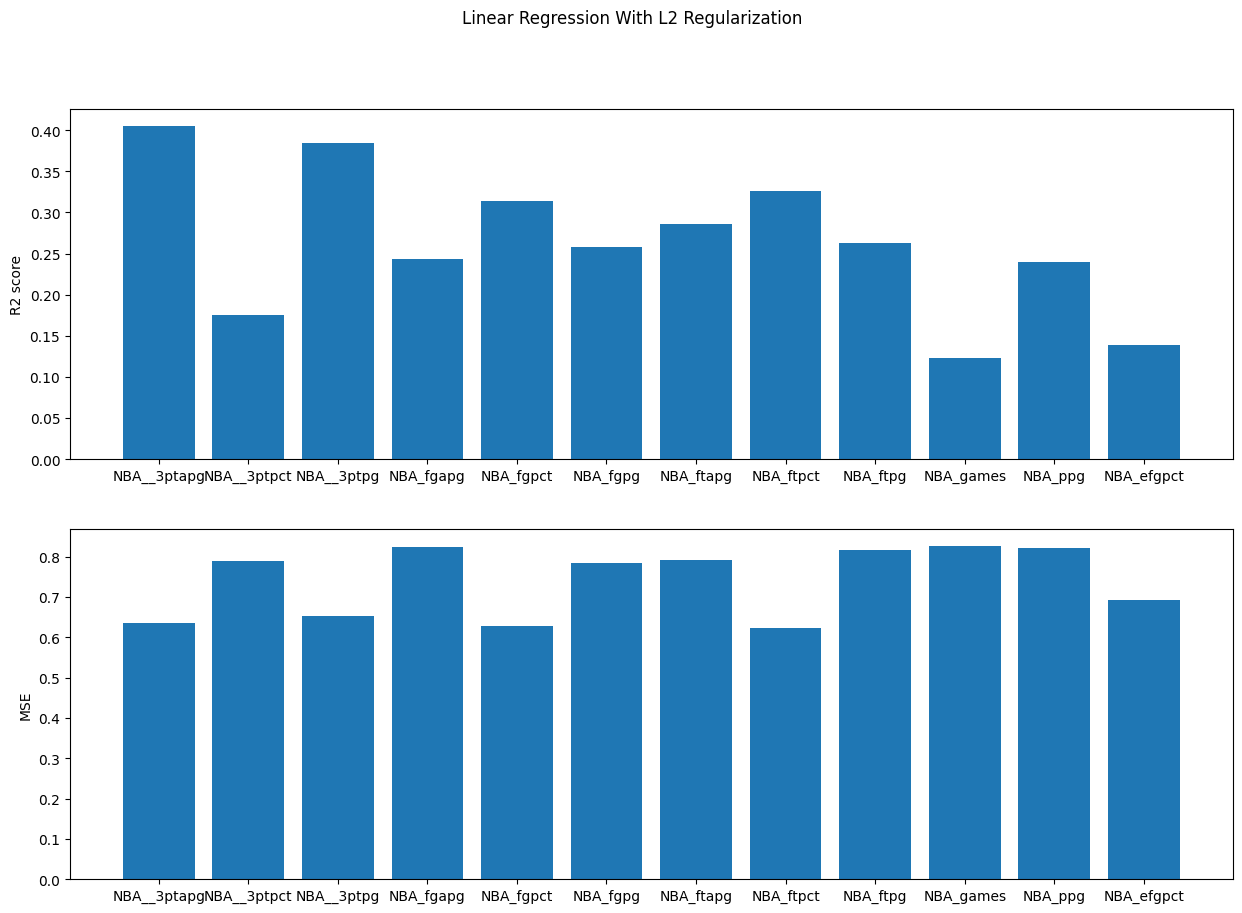

In [48]:
# Use grid search cross-validation to find the best value of the paramater alpha
model = GridSearchCV(Ridge(), param_grid = {'alpha': np.linspace(0.0, 2.0, 21)})
model.fit(X_train, y_train)
print('Best alpha parameter:', round(model.best_params_['alpha'], 2))
y_pred = model.predict(X_test)
stats_ridge = eval(y_test, y_pred, 'Linear Regression With L2 Regularization')

## Random Forest Regression

Best max_features parameter: 1
Average R2 score: 0.211
R2 score standard deviation: 0.080
Average MSE: 0.792
MSE standard deviation: 0.068
                    NBA__3ptapg  NBA__3ptpct  NBA__3ptpg  NBA_fgapg  \
R2 score               0.332211     0.162045    0.320759   0.205696   
Mean Squared Error     0.714500     0.802119    0.720693   0.865341   

                    NBA_fgpct  NBA_fgpg  NBA_ftapg  NBA_ftpct  NBA_ftpg  \
R2 score             0.230537  0.213627   0.248727   0.260756  0.230563   
Mean Squared Error   0.704040  0.830531   0.831382   0.682924  0.852880   

                    NBA_games   NBA_ppg  NBA_efgpct  
R2 score             0.076666  0.201022    0.051065  
Mean Squared Error   0.870196  0.862010    0.762852  


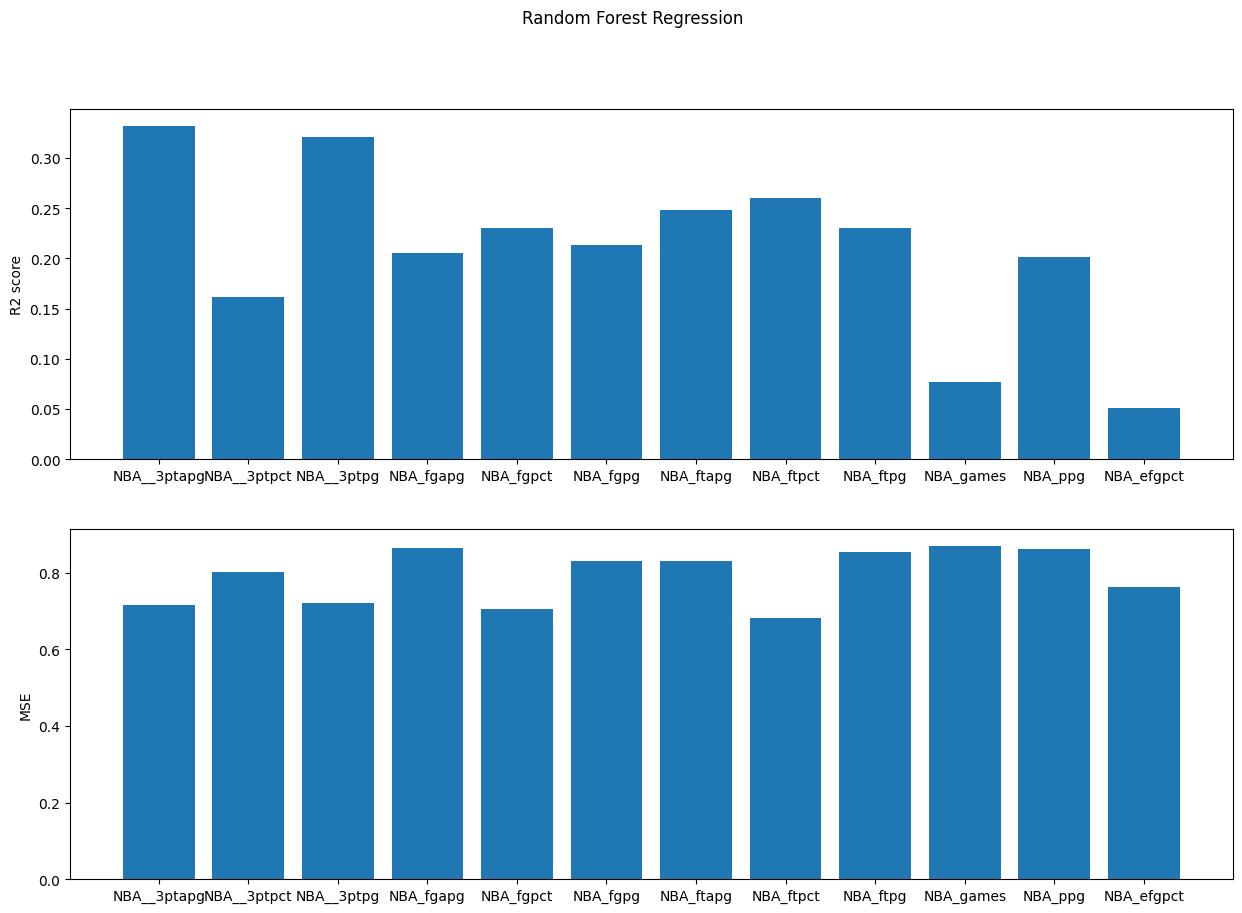

In [50]:
# Use grid search cross-validation to find the best value of the parameter max_features
model = GridSearchCV(RandomForestRegressor(), param_grid = {'max_features': np.arange(1, X_train.shape[1]+1)})
model.fit(X_train, y_train)
print('Best max_features parameter:', model.best_params_['max_features'])
y_pred = model.predict(X_test)
stats_ridge = eval(y_test, y_pred, 'Random Forest Regression')

## SVM

Best C parameter per target: [4.48, 1.91, 5.0, 0.36, 0.36, 0.62, 0.36, 0.87, 0.36, 0.1, 0.36, 0.1]
Average R2 score: 0.191
R2 score standard deviation: 0.084
Average MSE: 0.815
MSE standard deviation: 0.102
                    NBA__3ptapg  NBA__3ptpct  NBA__3ptpg  NBA_fgapg  \
R2 score               0.326636     0.142149    0.305772   0.153080   
Mean Squared Error     0.720465     0.821164    0.736595   0.922662   

                    NBA_fgpct  NBA_fgpg  NBA_ftapg  NBA_ftpct  NBA_ftpg  \
R2 score             0.273683  0.152999   0.192542   0.288700  0.162311   
Mean Squared Error   0.664563  0.894563   0.893559   0.657109  0.928533   

                    NBA_games   NBA_ppg  NBA_efgpct  
R2 score             0.053743  0.147627    0.094676  
Mean Squared Error   0.891800  0.919618    0.727793  


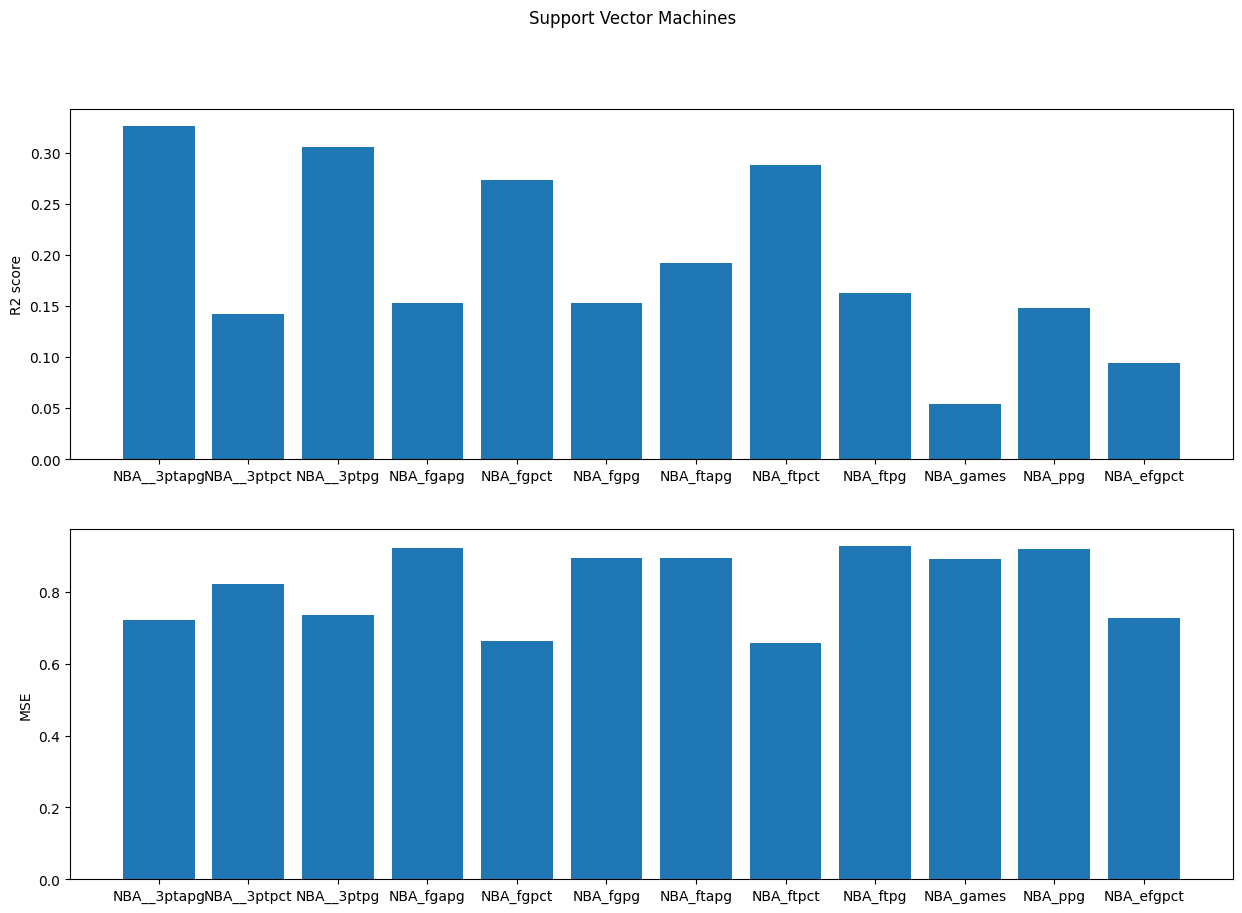

In [51]:
# Use grid search cross-validation to find the best value of the regularization parameter C
model = MultiOutputRegressor(GridSearchCV(SVR(), param_grid = {'C': np.linspace(0.1, 5.0, 20)}))
model.fit(X_train, y_train)
print('Best C parameter per target:', [round(m.best_params_['C'], 2) for m in model.estimators_])
y_pred = model.predict(X_test)
stats_ridge = eval(y_test, y_pred, 'Support Vector Machines')

## Neural Network

Best hidden layer sizes per target: [[64], [128], [64], [64], [128], [128], [64], [128], [64], [64], [128], [64]]
Average R2 score: 0.212
R2 score standard deviation: 0.099
Average MSE: 0.790
MSE standard deviation: 0.075
                    NBA__3ptapg  NBA__3ptpct  NBA__3ptpg  NBA_fgapg  \
R2 score               0.378262     0.116327    0.343848   0.224024   
Mean Squared Error     0.665228     0.845881    0.696194   0.845373   

                    NBA_fgpct  NBA_fgpg  NBA_ftapg  NBA_ftpct  NBA_ftpg  \
R2 score             0.252173  0.244712   0.252208   0.199920  0.254335   
Mean Squared Error   0.684243  0.797700   0.827530   0.739125  0.826529   

                    NBA_games   NBA_ppg  NBA_efgpct  
R2 score             0.044669  0.186237     0.04343  
Mean Squared Error   0.900351  0.877962     0.76899  


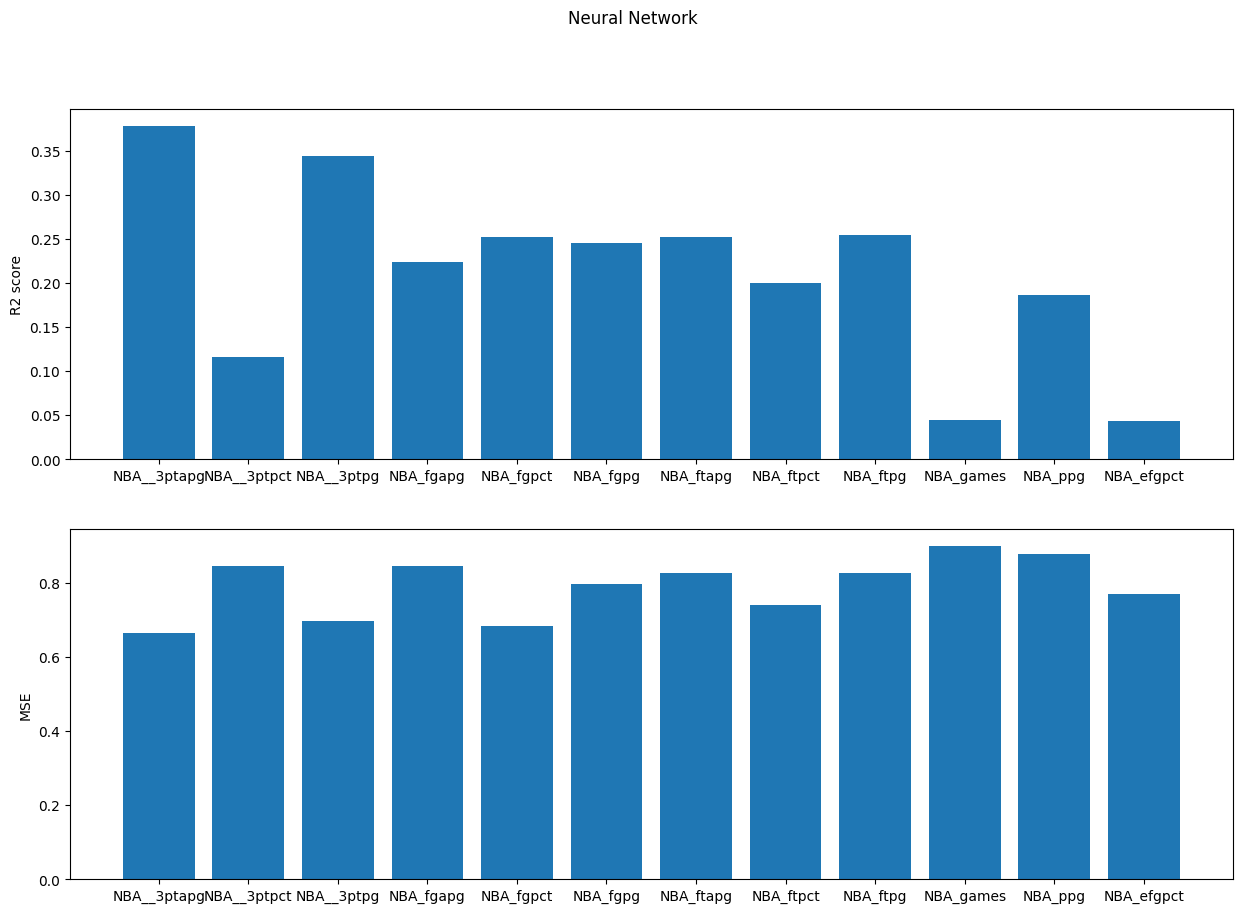

In [52]:
# Use grid search cross-validation to find the best combination of hidden layer sizes
model = MultiOutputRegressor(GridSearchCV(MLPRegressor(learning_rate_init=0.05, learning_rate='adaptive'),
                                          param_grid = {'hidden_layer_sizes': [[64], [128], [64, 32], [128, 64, 32]]}))
model.fit(X_train, y_train)
print('Best hidden layer sizes per target:', [m.best_params_['hidden_layer_sizes'] for m in model.estimators_])
y_pred = model.predict(X_test)
stats_ridge = eval(y_test, y_pred, 'Neural Network')

## Linear Regression Models With 1D Input

Average R2 score: 0.194
R2 score standard deviation: 0.087
Average MSE: 0.828
MSE standard deviation: 0.096
                    NBA__3ptapg  NBA__3ptpct  NBA__3ptpg  NBA_fgapg  \
R2 score               0.240825     0.049326    0.232574   0.191435   
Mean Squared Error     0.812279     0.910017    0.814260   0.880876   

                    NBA_fgpct  NBA_fgpg  NBA_ftapg  NBA_ftpct  NBA_ftpg  \
R2 score             0.275765  0.220034   0.206550   0.330215  0.186207   
Mean Squared Error   0.662657  0.823764   0.878056   0.618756  0.902045   

                    NBA_games   NBA_ppg  
R2 score             0.011395  0.191844  
Mean Squared Error   0.931711  0.871912  


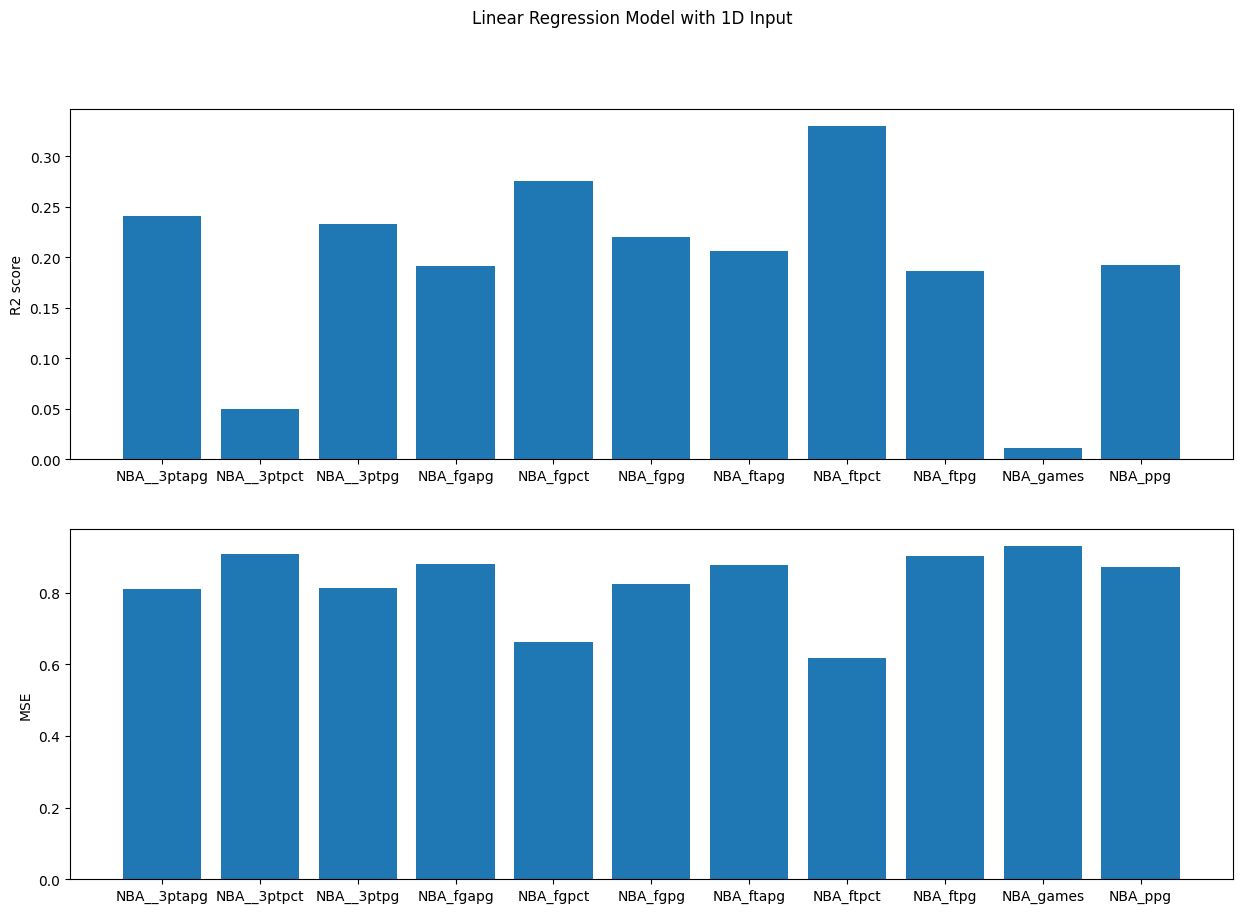

In [53]:
y_pred = np.zeros((y_test.shape[0], X_train.shape[1]))
for i in range(X_train.shape[1]):
    model = LinearRegression()
    model.fit(X_train[:, i].reshape(-1, 1), y_train[:, i])
    y_pred[:, i] = model.predict(X_test[:, i].reshape(-1, 1))
stats_ridge = eval(y_test[:, :X_train.shape[1]], y_pred, 'Linear Regression Model with 1D Input')

# Conclusion

Almost every performance statistics in the NCAA has some correlation with the corresponding performance statistics in the NBA, therefore it is reasonable to assume that the NBA performance can be estimated to some extend by using the NCAA performance data. Also multicollinearity occurs between most of the NCAA columns, implying that the predictive ability of those variables is limited.  
The best performing model on average among the tested is the linear regression model with l2 regularization (Ridge regression). It reached the average $R^2$ score of 0.263 across all of the NBA performance metrics.  
Variation in predictability of the NBA performance metrics is mostly similar for every model. The most predictable statistics are NBA__3ptapg, NBA__3ptpg, NBA_fgpct and NBA_ftpct. The Ridge regression model is best used to predict NBA__3ptapg, NBA__3ptpg and NBA_fgpct, with $R^2$ scores 0.405, 0.384, 0.314 and 0.326 respectively. The NBA_ftpct metrics can be better predicted with a linear model based only on the NCAA_ftpct metrics, with 0.33 $R^2$ score.